# Prediction of regulatory regions using Deep Neural Networks

Within this jupyter notebook we will discuss how to retrieve the epigenomic and sequence data and the labels necessary to predict novel regulatory regions ([enhancers](https://en.wikipedia.org/wiki/Enhancer_(genetics)) and [promoters](https://en.wikipedia.org/wiki/Promoter_(genetics))).

We will start with a brief introduction including some basic definitions, followed by the data retrieval and an overview of some feature selection methods (method to select which features are actually useful), then visualization of the retrieved data.

Aftewards, we will start building the models we want to run on these data, namely a Perceptron, an Multi-Layer Perceptron (MLP), a Feed-Forward Neural Network (FFNN), a Convolutional Neural Network (CNN).

We will then combine the FFNN and CNN into a Multi-Modal Neural Network (MMNN).

Finally we will build meta-models based on Bayesian optimization.

We will define the models evaluation schema and then train and evaluate the aforementioned models.

## Table of contents
In this jupyter notebook we will be discussing:

- Introduction
    - What are regulatory regions
        - Enhancers
        - Promoters
    - What are Neural Networks
        - Convolutional neural networks
        - Multi-modal neural networks
    - What are meta-models
        - Bayesian optimization
- Retrieving the data and labels
    - Considered tissues
    - Retrieving the labels from FANTOM5
    - Binarization of the labels
        - Global thresholds
        - Per tissue thresholds
    - The epigenomic data
        - Imputation of missing data
    - The sequence data
    - Prediction tasks
        - Classification tasks
        - Regression tasks
- Feature selection of epigenomic data
    - Correlation between features
        - Pearson
        - Spearman
        - MIC
    - Correlation between features and labels
        - Pearson
        - Spearman
        - MIC
    - Boruta
- Notes on utilities
    - Cache
- Data visualization
    - PCA
    - TSNE
    - Visualization of epigenomic data
    - Visualization of sequence data
- Creating a Neural Network model
    - Creating a Perceptron
    - Creating a Multi-Layer Perceptron (MLP)
    - Creating a Feed-Forward Neural Network (FFNN)
    - Creating a Convolutional Neural Network (CNN)
    - Creating a Multi-Modal Neural Network (MMNN)
- Creating a Meta Model
    - Creating a meta-model FFNN
    - Creating a meta-model CNN
    - Creating a meta-model MMNN
- Model evaluation
    - k-folds
    - Monte Carlo Holdouts
    - Evaluation metrics
- Training the models

## Introduction

### What are regulatory regions
In DNA, regulation of gene expression normally happens at the level of RNA biosynthesis (transcription), and is accomplished through the sequence-specific binding of proteins (transcription factors) that activate or inhibit transcription. Transcription factors may act as activators, repressors, or both. Repressors often act by preventing RNA polymerase from forming a productive complex with the transcriptional initiation region (promoter), while activators facilitate formation of a productive complex. Furthermore, DNA motifs have been shown to be predictive of epigenomic modifications, suggesting that transcription factors play a role in regulating the epigenome [(Whitaker et al.)](https://www.nature.com/articles/nmeth.3065).

![Regulatory regions](https://upload.wikimedia.org/wikipedia/commons/d/d7/Regulation_of_transcription_in_mammals.jpg)

#### Enhancers
In genetics, an enhancer is a short (**50–1500 bp**) region of DNA that can be bound by proteins (activators) to increase the likelihood that transcription of a particular gene will occur. These proteins are usually referred to as transcription factors. Enhancers are cis-acting. They can be located up to 1 Mbp (1,000,000 bp) away from the gene, upstream or downstream from the start site. There are hundreds of thousands of enhancers in the human genome. They are found in both prokaryotes and eukaryotes ([(Blackwood et al.)](https://science.sciencemag.org/content/281/5373/60), [(Pennacchio et al.)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4445073/)).

*The fact that the sequence length of an enhancer is between 50 and 1500 base pairs (number of nucleotides) suggests that the models we will have to design that exploit the sequence data should consider sequences of that size.*

*The fact that the enhancers are so far from a gene (upwards to 1Mbp) makes predicting what gene a given enhancer is regulating difficult.*

#### Promoters
In genetics, a promoter is a sequence of DNA to which proteins bind that initiate transcription of a single RNA from the DNA downstream of it. This RNA may encode a protein, or can have a function in and of itself, such as tRNA, mRNA, or rRNA. Promoters are located near the transcription start sites of genes, upstream on the DNA (towards the 5' region of the sense strand). Promoters can be about 100–1000 base pairs long, the sequence of which is highly dependent on the gene and product of transcription, type or class of RNA polymerase recruited to the site and species of organism. [(Sharan et al.)](http://www.cs.tau.ac.il/~roded/courses/bnet-a06/lec11.pdf)

*The fact that the sequence length of a promoter is between 100 to 1000 base pairs suggests that the models we will have to design that exploit the sequence data should consider sequences of that size.*

### What are Deep Neural Networks
A deep neural network (DNN) is an artificial neural network (ANN) with multiple layers between the input and output layers. There are different types of neural networks but they boild down to weight matrices multiplications that are trained using some form of [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent#:~:text=Gradient%20descent%20is%20a%20first,the%20direction%20of%20steepest%20descent.).

For example, a DNN that is trained to recognize dog breeds will go over the given image and calculate the probability that the dog in the image is a certain breed. The user can review the results and select which probabilities the network should display (above a certain threshold, etc.) and return the proposed label. Each mathematical manipulation as such is considered a layer, and complex DNN have many layers, hence the name "deep" networks. DNNs can approximate complex non-linear relationships.

Deep architectures include many variants of a few basic approaches. Each architecture has found success in specific domains. It is not always possible to compare the performance of multiple architectures, unless they have been evaluated on the same data sets.

DNNs are typically feedforward networks (FFNN) in which data flows from the input layer to the output layer without looping back.

#### Convolutional neural networks
The following is a succinct version of [this article from WikiPedia](https://en.wikipedia.org/wiki/Convolutional_neural_network).

In deep learning, a convolutional neural network (CNN) is a class of deep neural network, most commonly applied to analyze visual imagery. They have applications in image and video recognition, recommender systems, image classification, image segmentation, medical image analysis, natural language processing, brain-computer interfaces, and financial time series. 

*In our use case we will be training convolutional neural networks on the genomic sequences.*

Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "full connectivity" of these networks make them prone to overfitting data. Typical ways of regularization, or preventing overfitting, include: penalizing parameters during training (such as weight decay) or trimming connectivity (skipped connections, dropout, etc.) CNNs take a different approach towards regularization: **they take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters**. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme.

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

CNNs use relatively little pre-processing compared to other image classification algorithms. This means that the network learns to optimize the filters (or kernels) through automated learning, whereas in traditional algorithms these filters are hand-engineered. This independence from prior knowledge and human intervention in feature extraction is a major advantage.

A convolutional neural network consists of an input layer, hidden layers and an output layer. In any feed-forward neural network, any middle layers are called hidden because their inputs and outputs are masked by the activation function and final convolution. In a convolutional neural network, the hidden layers include layers that perform convolutions. Typically this includes a layer that performs a dot product of the convolution kernel with the layer's input matrix. This product is usually the Frobenius inner product, and its activation function is commonly ReLU. As the convolution kernel slides along the input matrix for the layer, the convolution operation generates a feature map, which in turn contributes to the input of the next layer. This is followed by other layers such as pooling layers, fully connected layers, and normalization layers.

##### Convolutional layers
In a CNN, the input is a tensor with a shape: (number of inputs) x (input height) x (input width) x (input channels). After passing through a convolutional layer, the image becomes abstracted to a feature map, also called an activation map, with shape: (number of inputs) x (feature map height) x (feature map width) x (feature map channels).

##### Pooling layers
Convolutional networks may include local and/or global pooling layers along with traditional convolutional layers. Pooling layers reduce the dimensions of data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer. Local pooling combines small clusters, tiling sizes such as 2 x 2 are commonly used. Global pooling acts on all the neurons of the feature map. There are two common types of pooling in popular use: max and average. Max pooling uses the maximum value of each local cluster of neurons in the feature map, while average pooling takes the average value.

##### Fully connected layers
Fully connected layers connect every neuron in one layer to every neuron in another layer. It is the same as a traditional multi-layer perceptron neural network (MLP). The flattened matrix goes through a fully connected layer to classify the images.

##### Receptive field
In neural networks, each neuron receives input from some number of locations in the previous layer. In a convolutional layer, each neuron receives input from only a restricted area of the previous layer called the neuron's receptive field. Typically the area is a square (e.g. 5 by 5 neurons). Whereas, in a fully connected layer, the receptive field is the entire previous layer. Thus, in each convolutional layer, each neuron takes input from a larger area in the input than previous layers. This is due to applying the convolution over and over, which takes into account the value of a pixel, as well as its surrounding pixels. When using dilated layers, the number of pixels in the receptive field remains constant, but the field is more sparsely populated as its dimensions grow when combining the effect of several layers.

#### Multi-modal neural networks
The information in real world usually comes as different modalities. For example, images are usually associated with tags and text explanations; texts contain images to more clearly express the main idea of the article. Different modalities are characterized by very different statistical properties. For instance, images are usually represented as pixel intensities or outputs of feature extractors, while texts are represented as discrete word count vectors. Due to the distinct statistical properties of different information resources, it is very important to discover the relationship between different modalities. Multimodal learning is a good model to represent the joint representations of different modalities. The multimodal learning model is also capable to fill missing modality given the observed ones. The multimodal learning model combines two Deep Neural Network each corresponds to one modality. An additional hidden layer is placed on top of the two Deep Neural Network to give the joint representation.

*In our use case, the different modalities considered are epigenomic and sequence data.*

### What are meta-models
A metamodel/ surrogate model is a model of the model. A model is an abstraction of phenomena in the real world; a metamodel is yet another abstraction, highlighting properties of the model itself. A model conforms to its metamodel in the way that a computer program conforms to the grammar of the programming language in which it is written. Various types of metamodels include polynomial equations, neural network, Kriging, etc. Metamodeling typically involves studying the output and input relationships and then fitting right metamodels to represent that behavior.

*We will be defining meta-models of neural networks and tune them using Bayesian optimization.*

#### Bayesian optimization
Bayesian optimization is a sequential design strategy for global optimization of black-box functions that does not assume any functional forms. *It is usually employed to optimize expensive-to-evaluate functions, in our use case the training of a neural network.*

Since the objective function is unknown, the Bayesian strategy is to treat it as a random function and place a prior over it. The prior captures beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criteria) that determines the next query point.

There are several methods used to define the prior/posterior distribution over the objective function. The most common two methods use Gaussian Processes in a method called Kriging. Another less expensive method uses the Parzen-Tree Estimator to construct two distributions for 'high' and 'low' points, and then finds the location that maximizes the expected improvement [(Bergstra et al.)](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

![](https://github.com/fmfn/BayesianOptimization/raw/master/examples/bayesian_optimization.gif)


## Retrieving the data and labels
In the following section we will retrieve the epigenomic data, sequence data and labels.

The python packages we will be using can be installed by running:

```bash
pip install crr_labels epigenomic_dataset ucsc_genomes_downloader
```

### Available tissue epigenomic data
Even though from the [FANTOM5](https://fantom.gsc.riken.jp/5/) dataset we have access to \(250\) cell lines labels relative to cis-regulatory regions, we only have a limited set of epigenomic data available from [ENCODE](https://www.encodeproject.org/): from the `epigenomic_dataset` we have made available the preprocessed epigenomic data for the following \(7\) cell lines.

#### A549
The [A549 cell line](http://www.a549.com/) was established in 1972 by D.J. Giard, et al., through an explant culture of adenocarcinomic lung tissue of a 58-year-old Caucasian male. A549 cells are hypotriploid alveolar basal epithelial cells. This adenocarcinomic cell line is categorized as a non-small-cell lung carcinoma (NSCLC), which tends to be less aggressive and spread less quickly than small cell lung carcinoma (SCLC) but proves to be more common, accounting for 85-88% of all cases of lung cancer. The A549 cell line is widely used as a model of lung adenocarcinoma, as well as an in vitro model for type II pulmonary epithelial cells. 

#### GM12878
The [GM12878 cell line](https://www.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=GM12878) is a lymphoblastoid cell line, transformed with the Epstein-Barr virus, that was selected by the International HapMap Project for whole genome and transcriptome sequencing by use of the Illumina platform.

#### H1
One of the most commonly used Human Embryonic stem cell line.

#### HEK293
[Human embryonic kidney 293 cells](https://en.wikipedia.org/wiki/HEK_293_cells), also often referred to as HEK 293, HEK-293, 293 cells, or less precisely as HEK cells, are a specific cell line originally derived from human embryonic kidney cells grown in tissue culture taken from a female fetus. HEK 293 cells have been widely used in cell biology research for many years, because of their reliable growth and propensity for transfection. They are also used by the biotechnology industry to produce therapeutic proteins and viruses for gene therapy.

#### HepG2
[HepG2](https://en.wikipedia.org/wiki/Hep_G2) is an immortal cell line which was derived in 1975 from the liver tissue of a 15-year-old Caucasian male from Argentina with a well-differentiated hepatocellular carcinoma

#### K562
[K562](https://en.wikipedia.org/wiki/K562_cells) cells were the first human immortalised myelogenous leukemia cell line to be established. K562 cells are of the erythroleukemia type, and the cell line is derived from a 53-year-old female chronic myelogenous leukemia patient in blast crisis.

#### MCF-7
[MCF-7](https://en.wikipedia.org/wiki/MCF-7) is a breast cancer cell line isolated in 1970 from a 69-year-old White woman. Prior to MCF-7, it was not possible for cancer researchers to obtain a mammary cell line that was capable of living longer than a few months.

In [9]:
from crr_labels import fantom_available_cell_lines
fantom_available_cell_lines()

,cell_line,code
0,10964C,CNhs11722
1,143B,CNhs11279
2,15242A,CNhs11723
3,15425,CNhs11724
4,1B2C6,CNhs11731
...,...,...
245,U937 DE4,CNhs13058
246,WAHT,CNhs11812
247,WIL2NS,CNhs11891
248,XPL 17,CNhs11813


In [7]:
from epigenomic_dataset.utils import get_cell_lines
get_cell_lines()

['A549', 'GM12878', 'H1', 'HEK293', 'HepG2', 'K562', 'MCF-7']

### Notes on the data preprocessing
A significant part of the preprocessing of the data that will be retrieved has already been completed previously as it requires downloading TBs of [BigWig](https://genome.ucsc.edu/goldenPath/help/bigWig.html) data from ENCODE and extract the informations relative to the labels [BED](https://genome.ucsc.edu/FAQ/FAQformat.html#format1) files using [bwtool](https://github.com/CRG-Barcelona/bwtool) and [pybwtool](https://github.com/LucaCappelletti94/pybwtool).

### Retrieval of the FANTOM5 labels
Even though we will show afterwards how to use tasks generators methods from the `epigenomic_dataset` package, for now we will retrieve the labels directly by using the `crr_labels` package.

When downloading the labels from FANTOM, the pipeline will download the raw data from FANTOM5 and automatically extract the relative files. This may take a while on slow connections, as the files amount to around 1GB of data.

In [19]:
from crr_labels import fantom

enhancers_fantom, promoters_fantom = fantom(
    # We retrieve the labels for all the cell lines we are interested in,
    # whose epigenomic datasets are already made available from the `epigenomic_dataset`
    # package.
    # Since in FANTOM5 the cell line MCF-7 is encoded as MCF7, we need to
    # remove the hyphen from the cell lines names.
    cell_lines=[
        cell_line.replace("-", "")
        for cell_line in get_cell_lines()
    ],
    # We will expand the sequence snippets to a size of 512
    window_size=512,
    # We will not, for now, binarize the tasks
    binarize=False
)

# We set the BED indices as index of the dataframes
enhancers_fantom.set_index(["chrom", "chromStart", "chromEnd", "strand"], inplace=True)
promoters_fantom.set_index(["chrom", "chromStart", "chromEnd", "strand"], inplace=True)

/root/anaconda3/lib/python3.7/site-packages/crr_labels/fantom.py:123: FutureWarning: The default value of regex will change from True to False in a future version.
  annotations = annotations.str.replace(r"\.\.", ",")


In [20]:
enhancers_fantom

A549   GM12878        H1    HEK293     HEPG2      K562      MCF7
chrom chromStart chromEnd strand                                                                      
chr1  839531     840043   .       0.166607  0.000000  0.000000  0.200923  0.000000  0.000000  0.000000
      840555     841067   .       0.000000  0.517058  0.000000  0.000000  0.000000  0.000000  0.000000
      856457     856969   .       0.000000  0.000000  0.000000  0.200923  0.000000  0.181105  0.000000
      858191     858703   .       0.000000  0.000000  0.000000  0.100461  0.000000  0.000000  0.495176
      868368     868880   .       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.247588
...                                    ...       ...       ...       ...       ...       ...       ...
chrY  14775219   14775731 .       0.000000  0.000000  0.648197  0.000000  0.074944  0.000000  0.000000
      15207144   15207656 .       0.000000  0.000000  1.296394  0.401845  0.449666  0.000000  0.000000
      28555041   28555553 .       0.000000  0.000000  0.000000  0.000000  0.149889  0.000000  0.000000
      58986510   58987022 .       0.000000  0.000000  0.000000  0.100461  0.000000  0.000000  0.000000
      59019105   59019617 .       0.000000  0.000000  0.000000  0.100461  0.000000  0.000000  0.000000

[28408 rows x 7 columns]

In [21]:
promoters_fantom

A549    GM12878          H1     HEK293      HEPG2       K562       MCF7
chrom chromStart chromEnd  strand                                                                               
chr10 100174900  100175412 -         4.277171   0.305654    0.666534   1.555323   1.575664   0.189754  33.855609
      100206642  100207154 -        35.414975  27.126759   11.331072  16.279046  13.629491  21.062664  28.647054
      101190374  101190886 -       125.406652  33.545485   25.994813  67.189948  46.560861  51.233508  27.605343
      101380158  101380670 -         4.790431   5.043285    7.331870   5.080721   4.648208   3.036060   2.864705
      101418801  101419313 +        11.291731   4.202737    3.999202   8.295055  19.538229   7.020888   4.948127
...                                       ...        ...         ...        ...        ...        ...        ...
chrY  21906594   21907106  -         1.539782   0.000000    6.665337   0.000000  13.708274   0.000000   0.000000
      22737106   22737618  +         1.881955   0.000000    0.000000   0.000000   5.987522   0.000000   0.000000
      22737157   22737669  +         6.843474   0.000000    0.000000   0.000000  46.797210   0.000000   0.000000
      22737208   22737720  +         4.619345   0.000000    0.000000   0.000000  26.628716   0.000000   0.000000
      2709141    2709653   +         8.383255   0.000000  183.296761   0.000000  51.209068   0.000000   0.000000

[22198 rows x 7 columns]

#### What are TPMs
The values reported in the data retrieved from FANTOM5 are TPMs, but what are TPMs?

The following is an [extract of this very nice blog post which explains in details what are TPMs](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/).

It used to be when you did RNA-seq, you reported your results in RPKM (Reads Per Kilobase Million) or FPKM (Fragments Per Kilobase Million). However, TPM (Transcripts Per Kilobase Million) is now becoming quite popular. Since there seems to be a lot of confusion about these terms, I thought I’d use a StatQuest to clear everything up.

These three metrics attempt to normalize for sequencing depth and gene length. Here’s how you do it for RPKM:

1. Count up the total reads in a sample and divide that number by 1,000,000 – this is our “per million” scaling factor.
2. Divide the read counts by the “per million” scaling factor. This normalizes for sequencing depth, giving you reads per million (RPM)
3. Divide the RPM values by the length of the gene, in kilobases. This gives you RPKM.

FPKM is very similar to RPKM. RPKM was made for single-end RNA-seq, where every read corresponded to a single fragment that was sequenced. FPKM was made for paired-end RNA-seq. With paired-end RNA-seq, two reads can correspond to a single fragment, or, if one read in the pair did not map, one read can correspond to a single fragment. The only difference between RPKM and FPKM is that FPKM takes into account that two reads can map to one fragment (and so it doesn’t count this fragment twice).

TPM is very similar to RPKM and FPKM. The only difference is the order of operations. Here’s how you calculate TPM:

1. Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).
2. Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
3. Divide the RPK values by the “per million” scaling factor. This gives you TPM.

So you see, when calculating TPM, the only difference is that you normalize for gene length first, and then normalize for sequencing depth second. However, the effects of this difference are quite profound.

When you use TPM, the sum of all TPMs in each sample are the same. This makes it easier to compare the proportion of reads that mapped to a gene in each sample. In contrast, with RPKM and FPKM, the sum of the normalized reads in each sample may be different, and this makes it harder to compare samples directly.

Here’s an example. If the TPM for gene A in Sample 1 is 3.33 and the TPM in sample B is 3.33, then I know that the exact same proportion of total reads mapped to gene A in both samples. This is because the sum of the TPMs in both samples always add up to the same number (so the denominator required to calculate the proportions is the same, regardless of what sample you are looking at.)

With RPKM or FPKM, the sum of normalized reads in each sample can be different. Thus, if the RPKM for gene A in Sample 1 is 3.33 and the RPKM in Sample 2 is 3.33, I would not know if the same proportion of reads in Sample 1 mapped to gene A as in Sample 2. This is because the denominator required to calculate the proportion could be different for the two samples.

#### Correlation between cell lines
Even though the enhancers and promoters that are active at a given time in a cell line may be different, there are some that are active/inactive in multiple cell lines at once.

We will measure with the Pearson and Spearman correlation how much this correlation is present in the FANTOM5 dataset and visualize the obtained scores using an heatmap from seaborn.

The presence of correlation between the different cell lines motivates the creation of multi-task models for what concerns the prediction of promoters.

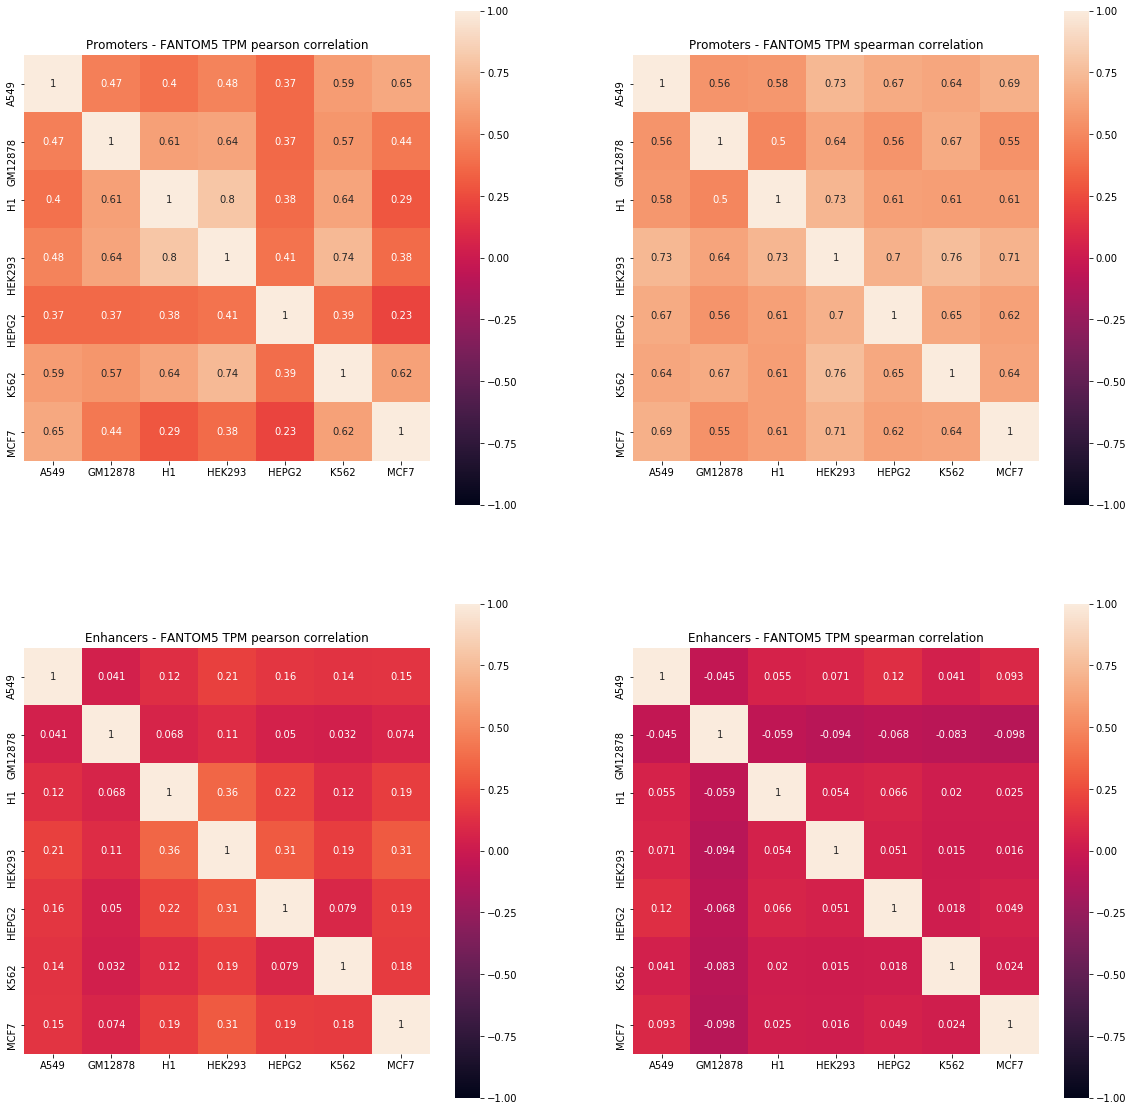

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(20, 20))

for i, (fantom_dataset, fantom_dataset_name) in enumerate(((promoters_fantom, "Promoters"), (enhancers_fantom, "Enhancers"))):
    for j, correlation in enumerate(("pearson", "spearman")):
        sns.heatmap(
            fantom_dataset.corr(method=correlation),
            vmin=-1,
            vmax=1,
            square=True,
            annot=True,
            ax=axes[i][j]
        )
        axes[i][j].set_title(f"{fantom_dataset_name} - FANTOM5 TPM {correlation} correlation")
plt.show()

We can see that indeed there exists a correlation between the different cell lines when measuring the TPM correlation of the **promoters**, while there is functionally no correlation in the **enhancers**. We can expect therefore that a multi-task model that is trained using all the cell lines at once, may be able to successfully predict the promoters but may fail or at least not perform better than a single-task model in the context of predicting enhancers.

#### Visualization of the cell lines distributions
In the following cell we show the histograms of the TPMs for the two considered cis-regulatory regions.

In both cases, most of the samples are very close to 0, but the range of the two datasets samples is extremely different: while in the enhancers most values fall within a bin from 0 to 20, the promoters fall within a bin from 0 to 5000. The clear presence of outliers in both datasets will make it necessary, in the context of the regression task, to clip the outliers values to a given maximal value.

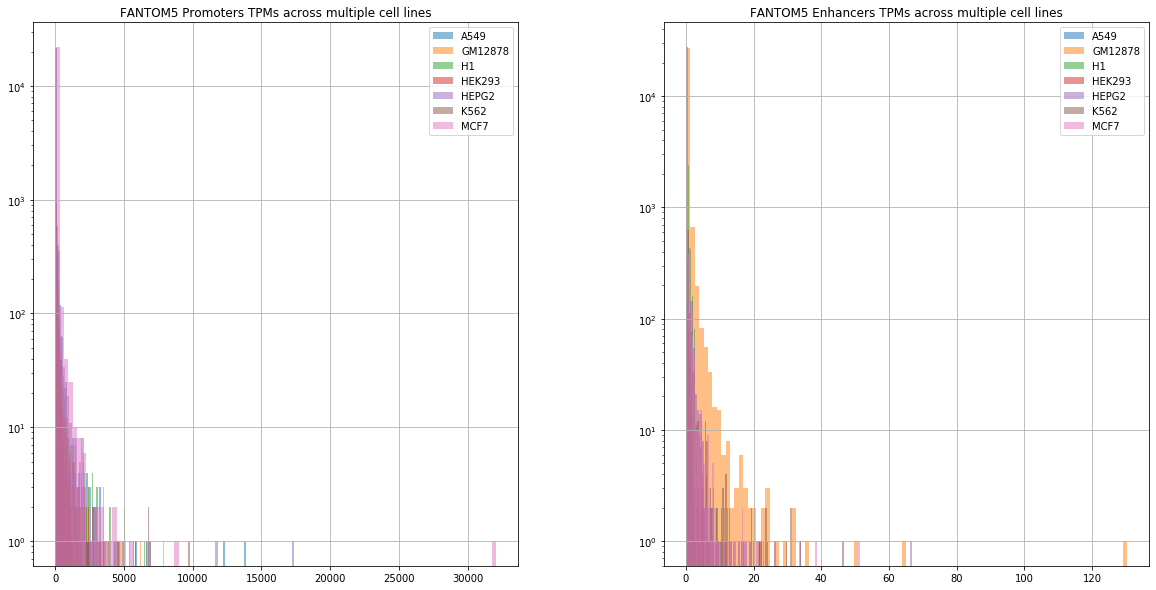

In [61]:
fig, ax = plt.subplots(ncols=2, squeeze=True, figsize=(20, 10))

for i, (fantom_dataset, fantom_dataset_name) in enumerate(((promoters_fantom, "Promoters"), (enhancers_fantom, "Enhancers"))):
    for column in fantom_dataset.columns:
        fantom_dataset[[column]].hist(
            bins=100,
            ax=ax[i],
            log=True,
            alpha=0.5,
            label=column
        )
    ax[i].set_title(f"FANTOM5 {fantom_dataset_name} TPMs across multiple cell lines")
    ax[i].legend()
plt.show()

#### Binarization of the labels
In order to convert the real values of the labels to a binary task, we can consider multiple approaches each one with its own issues. These approaches are yet to be properly vetted experimentally. It is hard to evaluate the impact of the different aproaches, as the models trained on the different datasets are not easily comparable.

1. Threshold at 5TPMs for promoters (dropping values between 0 and 5) and 0TPMs for enhancers. This setup, which has been adopted in [Wasserman et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5984344/), removes a significant portion of the promoters samples and does not take into account the issue of predicting values just above and just below the selected threshold for the enhancers.
2. Threshold at 1TPMs for both promoters and enhancers. This setup, which has been suggested by the FANTOM5 authors, does not take into account the issue of predicting values just above and just below the selected threshold for the enhancers. A possibility might be to weight less the errors done when predicting samples that are close to the threshold.
3. Threshold at 1TPMs, dropping values between 0 and 1 for both promoters and enhancers. This setup, which has been suggested by the FANTOM5 authors, removes a portion of the samples, but removes the issue of the threshold.
4. Compute tissue-specific thresholds for each of the cell lines.
5. Do not threshold the data, and use a regression task instead.

For the context of the project, we will use the solution 3.

### Retrieval of the ENCODE epigenomic data
Even though we will show afterwards how to use tasks generators methods from the `epigenomic_dataset` package, for now we will retrieve the data directly by using the `load_epigenomes` method which will return the epigenomic data for the given cell line and cis-regulatory region.

We will visualize through an heatmap the different TPMs of enhancers and promoters on the PCA and TSNE 2D decompositions, in order to identify eventual clear TPM gradients or clusters.

In [65]:
from epigenomic_dataset import load_epigenomes
for cell_line in get_cell_lines():
    for i, (fantom_dataset, fantom_dataset_name) in enumerate(((promoters_fantom, "Promoters"), (enhancers_fantom, "Enhancers"))):
        epigenomic_data, _ = load_epigenomes(
            cell_line=cell_line,
            window_size=512,
            region=fantom_dataset_name.lower()
        )
        

KeyboardInterrupt: 